In [1]:
import os
import sys
sys.path.append(os.path.normpath(os.path.join(os.getcwd(), "..")))
import math
import os
import pandas as pd
import numpy as np 

import torch
from torchvision import transforms

from nets.segmentation import TTUNet
from loaders.tt_dataset import TTDataModuleSeg, TrainTransformsFullSeg, EvalTransformsSeg
from callbacks.logger import SegImageLogger

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
csv_train = "/work/jprieto/data/remote/EGower/jprieto/PoPP_Analysis_Set_202306/PoPP_BESRAT_MTSS_202306_seg_stack_dice_train_train.csv"
csv_valid = "/work/jprieto/data/remote/EGower/jprieto/PoPP_Analysis_Set_202306/PoPP_BESRAT_MTSS_202306_seg_stack_dice_train_test.csv"
csv_test = "/work/jprieto/data/remote/EGower/jprieto/PoPP_Analysis_Set_202306/PoPP_BESRAT_MTSS_test_202306.csv"
batch_size = 2
num_workers = 2
img_column = "image path"
seg_column = "seg"
mount_point = "/work/jprieto/data/remote/EGower/"


df_train = pd.read_csv(csv_train)
df_val = pd.read_csv(csv_valid)
df_test = pd.read_csv(csv_test)

train_transform = TrainTransformsFullSeg()
eval_transform = EvalTransformsSeg()

ttdata = TTDataModuleSeg(df_train, df_val, df_test, batch_size=batch_size, num_workers=num_workers, img_column=img_column, seg_column=seg_column, mount_point=mount_point, train_transform=train_transform, valid_transform=eval_transform, test_transform=eval_transform)
ttdata.setup()

train_dataloader = ttdata.train_dataloader()

<class 'monai.transforms.utility.dictionary.AsChannelFirstd'>: Class `AsChannelFirstd` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead.
<class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if image is type `MetaTensor`.


In [3]:
batch = next(iter(train_dataloader))
print(batch["img"].shape)

torch.Size([2, 3, 5344, 5344])


In [4]:
def compute_bb(seg, label=3, pad=0):
    
    shape = seg.shape[1:]
    
    ij = torch.argwhere(seg.squeeze() == label)
    
    bb = torch.tensor([0, 0, 0, 0])# xmin, ymin, xmax, ymax

    bb[0] = torch.clip(torch.min(ij[:,1]) - shape[1]*pad, 0, shape[1])
    bb[1] = torch.clip(torch.min(ij[:,0]) - shape[0]*pad, 0, shape[0])
    bb[2] = torch.clip(torch.max(ij[:,1]) + shape[1]*pad, 0, shape[1])
    bb[3] = torch.clip(torch.max(ij[:,0]) + shape[0]*pad, 0, shape[0])
    
    return bb

def extract_patches(img, bb, N=5, out_size=(256, 256)):
    # Calculate the dimensions of the region of interest
    xmin, ymin, xmax, ymax = bb

    width = xmax - xmin
    height = ymax - ymin

    # Calculate the dimensions of each patch
    patch_width = torch.div(width, N, rounding_mode='floor')
    patch_height = torch.div(height, N, rounding_mode='floor')
    patches = []
    
    resize = transforms.Resize(out_size)

    # Slide a window over the region of interest and extract patches
    for j in range(ymin, ymax-patch_height+1, patch_height):
        for i in range(xmin, xmax-patch_width+1, patch_width): 
            patch = img[:, j:j+patch_height, i:i+patch_width]
            patches.append(resize(patch))

    return patches

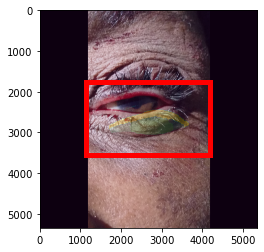

In [5]:


bb = compute_bb(batch["seg"][0], pad=0.1)

xmin, ymin, xmax, ymax = bb

fig, ax = plt.subplots(1)
# Display the image
ax.imshow(batch["img"][0].permute(1,2,0))

ax.imshow(batch["seg"][0].squeeze(), alpha=0.2)

# Create a Rectangle patch
rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax-ymin, linewidth=5, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()



torch.Size([25, 3, 256, 256])
torch.Size([25, 256, 256, 3])


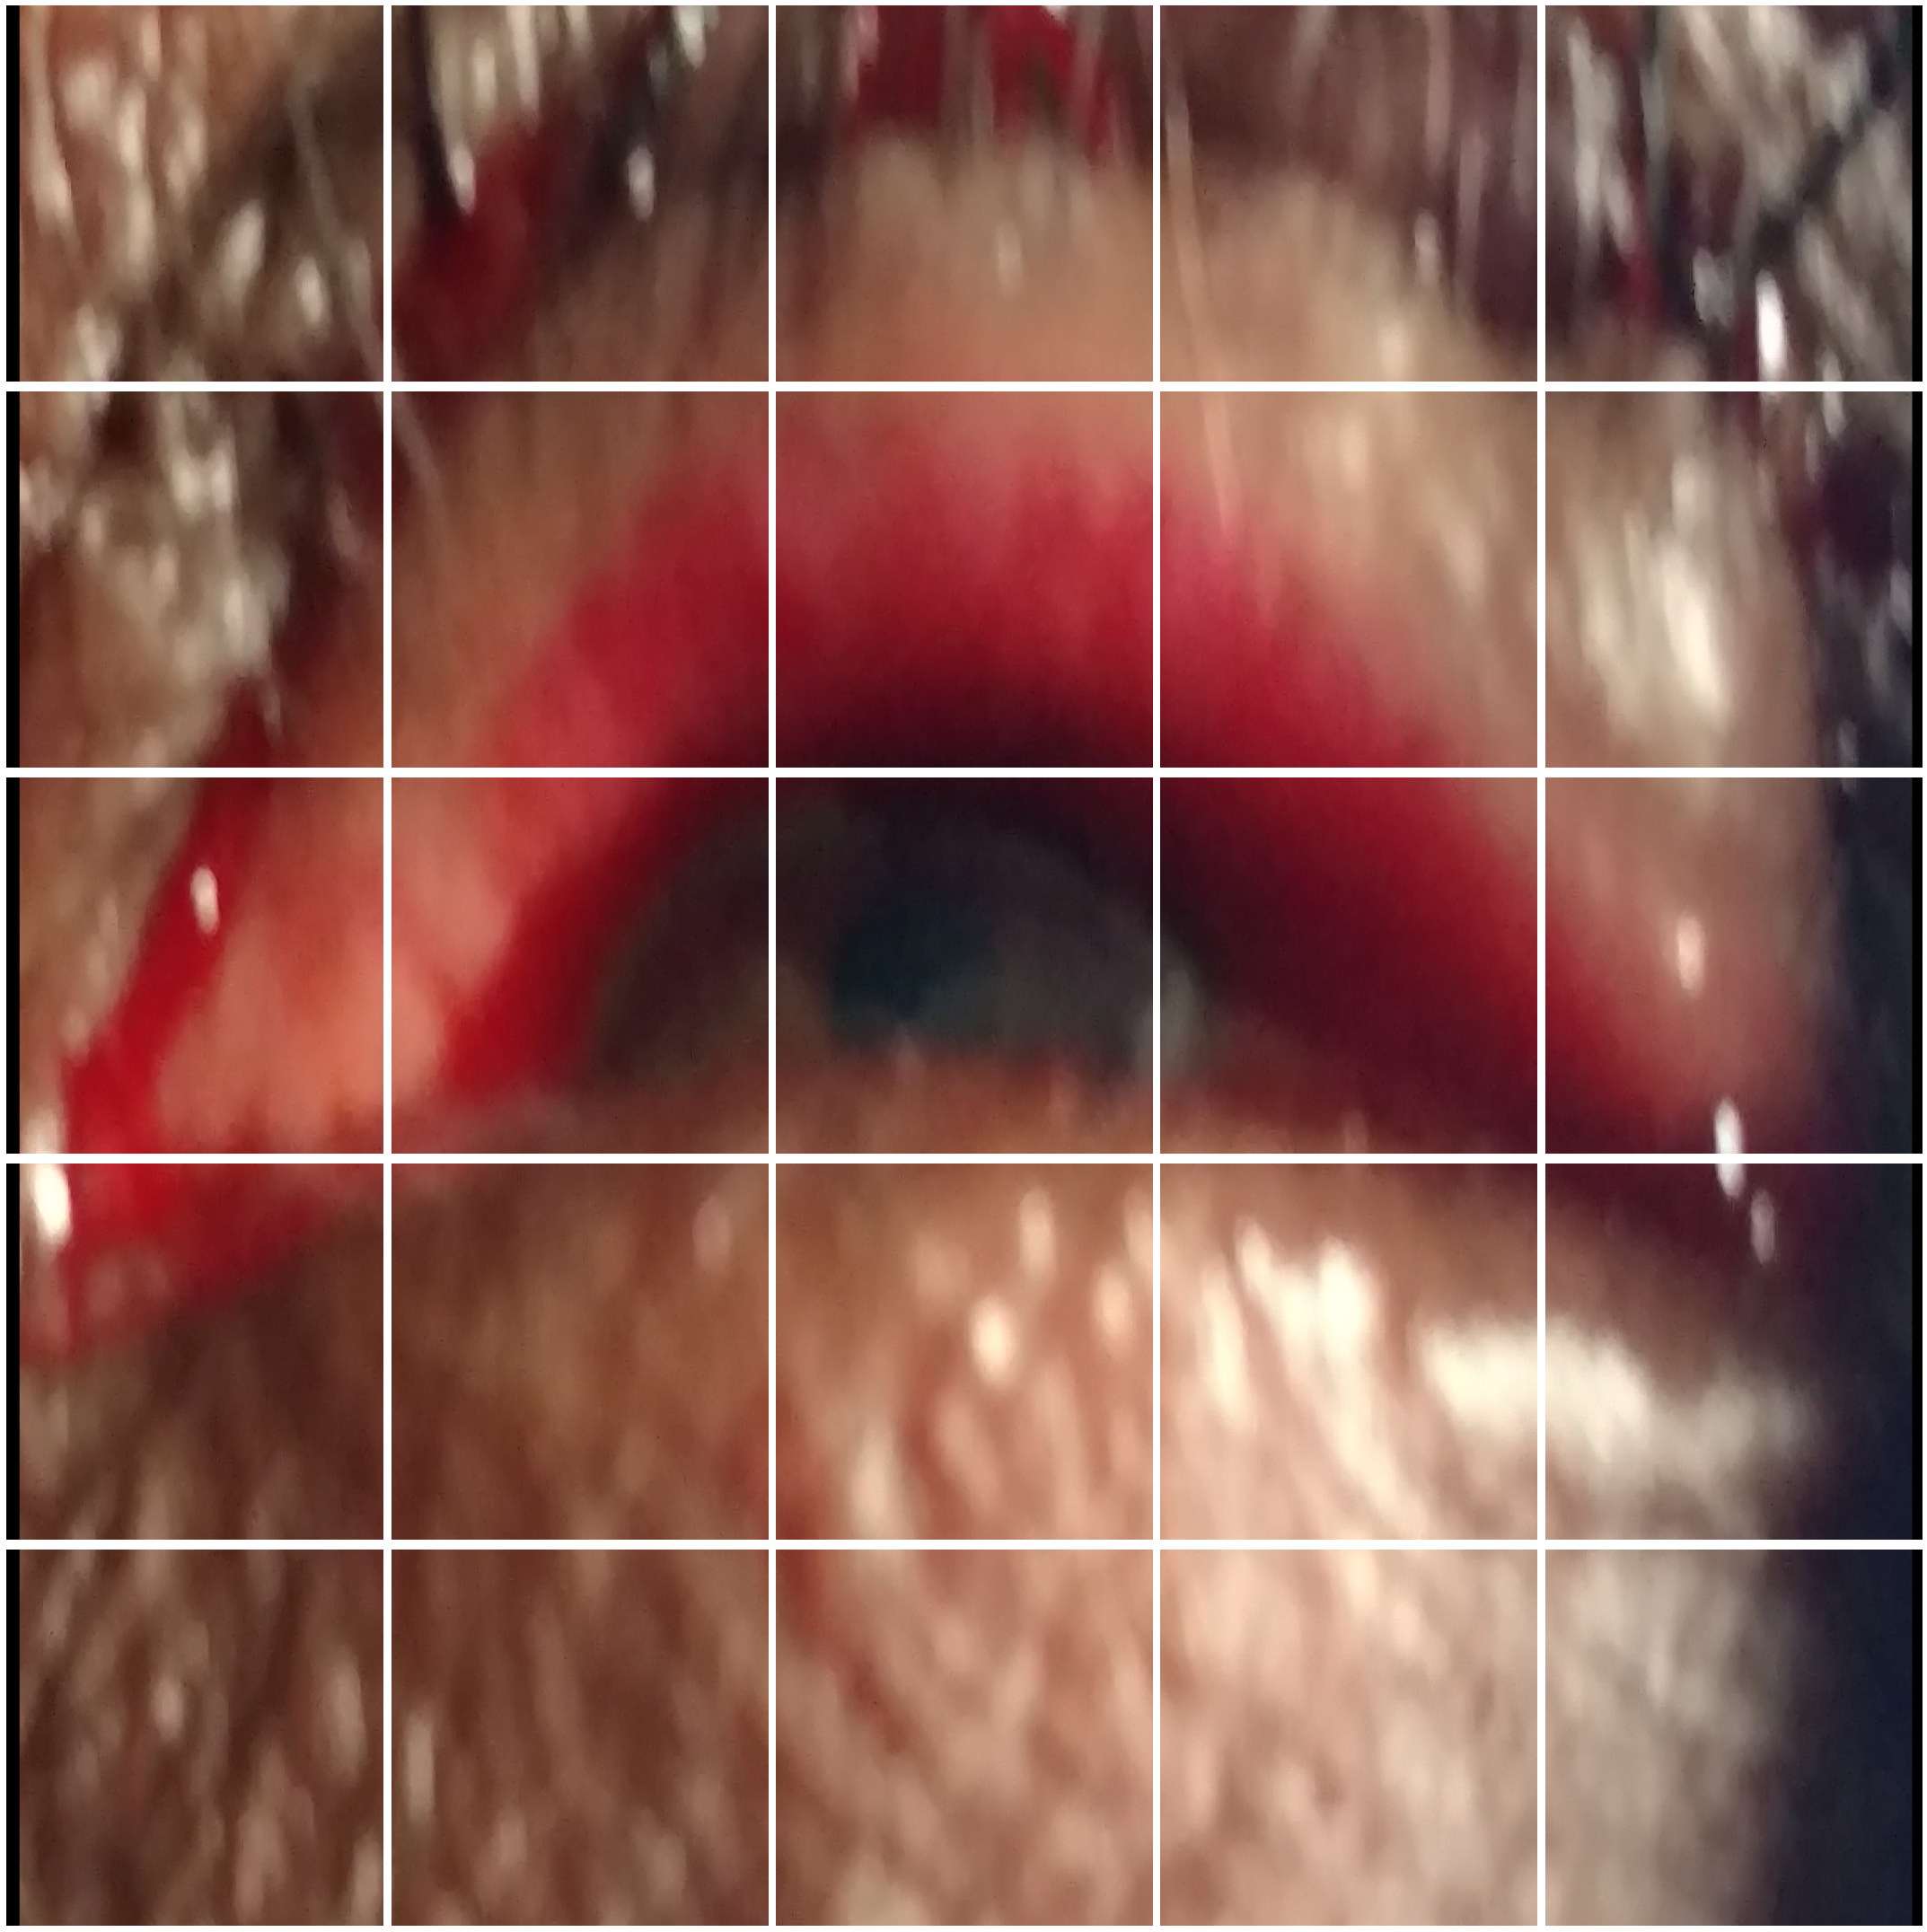

In [6]:

stack = extract_patches(batch["img"][1], bb, N=5)
print(torch.stack(stack).shape)


stack_c = torch.stack(stack).permute(0,2,3,1)
print(stack_c.shape)

cols = 5  # define the number of columns in the grid

n = len(stack_c)
rows = n // cols 
rows += n % cols

fig, axes = plt.subplots(rows, cols, figsize=(30,30))
for ax, p in zip(axes.flatten(), stack_c):
    ax.imshow(p)
    ax.axis('off') 
plt.tight_layout()
plt.show()

In [7]:
class RandomRotate:
    def __init__(self, degrees, keys, interpolation, prob=0.5):        
        self.degrees = degrees
        self.keys = keys
        self.interpolation = interpolation
        self.prob = prob

    def __call__(self, X):

        if self.prob > torch.rand(1):

            angle = torch.rand(1)*self.degrees
            
            for k, interp in zip(self.keys, self.interpolation):
                X[k] = transforms.functional.rotate(X[k], angle=angle.item(), interpolation=interp)

            return X

        return X

class RandomFlip:
    def __init__(self, keys, prob=0.5):
        self.keys = keys   
        self.prob = prob

    def __call__(self, X):

        if self.prob > torch.rand(1):
            for k in self.keys:
                X[k] = transforms.functional.hflip(X[k])
            return X

        return X
    
spatial_train_transform = transforms.Compose(
    [
        RandomRotate(degrees=90, keys=["img", "seg"], interpolation=[transforms.functional.InterpolationMode.NEAREST, transforms.functional.InterpolationMode.NEAREST], prob=0.5), 
        RandomFlip(keys=["img", "seg"], prob=0.5)
    ]
)

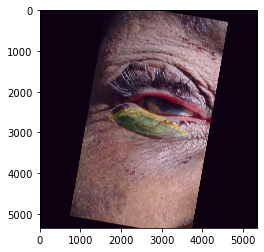

In [8]:
batch_st = spatial_train_transform(batch)

xmin, ymin, xmax, ymax = bb

fig, ax = plt.subplots(1)
# Display the image
ax.imshow(batch["img"][0].permute(1,2,0))
ax.imshow(batch["seg"][0].squeeze(), alpha=0.2)
plt.show()